<a href="https://colab.research.google.com/github/minjaering/TIL2/blob/main/cohort_%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## 코랩에서 한글폰트를 볼수있는 방법 - 런타임 재시작 후 다시돌리기
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic')
mpl.font_manager._rebuild()

# 해당 코드 실행이 완료되면, 반드시 상단의 런타임 > 런타임 다시 시작 누르기. 그리고 재실행

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import pandas as pd # python에서의 엑셀과 같은 역할
import numpy as np # 계산을 편하게 해 주는 라이브러리
import matplotlib.pyplot as plt # 시각화 ㅊㅊㅊ
import seaborn as sns # 시각화

import matplotlib.ticker as ticker # 시각화
import matplotlib.dates as mdates # 시각화

import warnings
warnings.filterwarnings('ignore')

In [ ]:
## 구글 드라이브 연동 시켜주기 

from google.colab import drive
drive.mount('/content/gdrive') ## 경로 디폴트

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# _01. 데이터 로드

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Product_Analysis/data/df_seat.csv')
df_seat = df.copy()
df_seat.head()

,user_key,sales_key,branch,sales_type,items,term,paid_by,paid_date,start_date,end_date,...,paid_month,start_month,end_month,start_day,next_start_date,user_lead_1,user_check,elapsed_days,item_seg,item_seg_np
0,1,1067235,01호,매출,자유석,1,카드,2021-04-11,2021-04-11,2021-05-10,...,4,4,5,Sunday,2021-04-03,2,-1,NaN,자유,자유
1,2,1055317,01호,매출,싱글석,3,카드,2021-03-28,2021-04-03,2021-07-02,...,3,4,7,Saturday,2021-07-03,2,0,0.0,고정,고정
2,2,1136132,01호,매출,싱글석,2,카드,2021-06-27,2021-07-03,2021-08-31,...,6,7,8,Saturday,2021-09-01,2,0,0.0,고정,고정
3,2,1210305,01호,매출,싱글석,1,카드,2021-08-31,2021-09-01,2021-09-30,...,8,9,9,Wednesday,2021-10-01,2,0,0.0,고정,고정
4,2,1239778,01호,매출,싱글석,1,카드,2021-09-30,2021-10-01,2021-10-30,...,9,10,10,Friday,2021-06-19,3,-1,NaN,고정,고정


    * 실습 목적
        * 1년( 12개월 )의 월 결제 데이터를 통해
        * Retention을 알아보고,
        * 시기별로 어떠한 특성이 있는 지 찾아보기

## 1.1. 데이터 spec 파악

In [ ]:
df_seat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71293 entries, 0 to 71292
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_key            71293 non-null  int64  
 1   sales_key           71293 non-null  int64  
 2   branch              71293 non-null  object 
 3   sales_type          71293 non-null  object 
 4   items               71293 non-null  object 
 5   term                71293 non-null  int64  
 6   paid_by             71293 non-null  object 
 7   paid_date           71293 non-null  object 
 8   start_date          71293 non-null  object 
 9   end_date            71293 non-null  object 
 10  payment_type        71293 non-null  object 
 11  discount            71293 non-null  int64  
 12  paid_amount         71293 non-null  int64  
 13  avg_paid_amount_1   71293 non-null  float64
 14  avg_paid_amount     61454 non-null  float64
 15  avg_paid_amount_np  61454 non-null  float64
 16  paid

## 1.2. Cohort에 필요한 컬럼만 가져오기

In [ ]:
df_base = df_seat[['user_key', 'branch', 'sales_type', 'items', 'paid_date', 'item_seg']]
df_base.head()

,user_key,branch,sales_type,items,paid_date,item_seg
0,1,01호,매출,자유석,2021-04-11,자유
1,2,01호,매출,싱글석,2021-03-28,고정
2,2,01호,매출,싱글석,2021-06-27,고정
3,2,01호,매출,싱글석,2021-08-31,고정
4,2,01호,매출,싱글석,2021-09-30,고정


# _02. data cleansing

## 2.1. 매출만 남기기

In [ ]:
df_base['sales_type'].unique().tolist()

['매출', '매출취소']

In [ ]:
## 매출만 보기
df_base = df_base[df_base['sales_type'] == '매출']
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63104 entries, 0 to 71292
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_key    63104 non-null  int64 
 1   branch      63104 non-null  object
 2   sales_type  63104 non-null  object
 3   items       63104 non-null  object
 4   paid_date   63104 non-null  object
 5   item_seg    63104 non-null  object
dtypes: int64(1), object(5)
memory usage: 3.4+ MB


## 2.2. data type 맞추기

    * 날짜 데이터가 문자열로 되어있다
    * 문자열 → 날짜 형식으로 data type을 변경 해 줌

In [ ]:
## 형변환 다른 방법 : df_base['paid_date'] = df_base['paid_date'].astype('datetime64[ns]')
df_base['paid_date'] = pd.to_datetime(df_base['paid_date'], format = '%Y-%m-%d') ## YYYY-mm-dd
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63104 entries, 0 to 71292
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_key    63104 non-null  int64         
 1   branch      63104 non-null  object        
 2   sales_type  63104 non-null  object        
 3   items       63104 non-null  object        
 4   paid_date   63104 non-null  datetime64[ns]
 5   item_seg    63104 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 3.4+ MB


In [ ]:
df_base.head(5)

,user_key,branch,sales_type,items,paid_date,item_seg
0,1,01호,매출,자유석,2021-04-11,자유
1,2,01호,매출,싱글석,2021-03-28,고정
2,2,01호,매출,싱글석,2021-06-27,고정
3,2,01호,매출,싱글석,2021-08-31,고정
4,2,01호,매출,싱글석,2021-09-30,고정


# _03. 분석하기 좋은 data로 만들기

## 3.1. 최초 구매일 컬럼 생성

In [ ]:
df_base.head(10)

,user_key,branch,sales_type,items,paid_date,item_seg
0,1,01호,매출,자유석,2021-04-11,자유
1,2,01호,매출,싱글석,2021-03-28,고정
2,2,01호,매출,싱글석,2021-06-27,고정
3,2,01호,매출,싱글석,2021-08-31,고정
4,2,01호,매출,싱글석,2021-09-30,고정
5,3,01호,매출,셀석,2021-06-18,자유
6,3,01호,매출,셀석,2021-06-20,자유
8,4,01호,매출,자유석,2021-06-29,자유
9,5,01호,매출,1day,2021-04-16,단기
10,5,01호,매출,자유석,2021-04-17,자유


In [ ]:
df_base = df_base.sort_values(by=['user_key', 'paid_date'], ascending=True)
df_base.head(10)

,user_key,branch,sales_type,items,paid_date,item_seg
0,1,01호,매출,자유석,2021-04-11,자유
1,2,01호,매출,싱글석,2021-03-28,고정
2,2,01호,매출,싱글석,2021-06-27,고정
3,2,01호,매출,싱글석,2021-08-31,고정
4,2,01호,매출,싱글석,2021-09-30,고정
5,3,01호,매출,셀석,2021-06-18,자유
6,3,01호,매출,셀석,2021-06-20,자유
8,4,01호,매출,자유석,2021-06-29,자유
9,5,01호,매출,1day,2021-04-16,단기
10,5,01호,매출,자유석,2021-04-17,자유


In [ ]:
df_base['first_paid'] = df_base.groupby(['user_key'])['paid_date'].transform('min')
df_base.head()

,user_key,branch,sales_type,items,paid_date,item_seg,first_paid
0,1,01호,매출,자유석,2021-04-11,자유,2021-04-11
1,2,01호,매출,싱글석,2021-03-28,고정,2021-03-28
2,2,01호,매출,싱글석,2021-06-27,고정,2021-03-28
3,2,01호,매출,싱글석,2021-08-31,고정,2021-03-28
4,2,01호,매출,싱글석,2021-09-30,고정,2021-03-28


## 3.2. 월 단위 형태로 data 맞추기

In [ ]:
# .dt.strftime
df_base['paid_ym'] = df_base['paid_date'].dt.strftime("%Y-%m") ## yyyy-mm
df_base['first_ym'] = df_base['first_paid'].dt.strftime("%Y-%m")
df_base.head()

,user_key,branch,sales_type,items,paid_date,item_seg,first_paid,paid_ym,first_ym
0,1,01호,매출,자유석,2021-04-11,자유,2021-04-11,2021-04,2021-04
1,2,01호,매출,싱글석,2021-03-28,고정,2021-03-28,2021-03,2021-03
2,2,01호,매출,싱글석,2021-06-27,고정,2021-03-28,2021-06,2021-03
3,2,01호,매출,싱글석,2021-08-31,고정,2021-03-28,2021-08,2021-03
4,2,01호,매출,싱글석,2021-09-30,고정,2021-03-28,2021-09,2021-03


### 3.2.1 data range 확인

### 2021년 1년동안의 데이터가 맞는지 확인

In [ ]:
## 12 달치 외에도 한달이 껴있나? 
print(df_base['paid_ym'].nunique())
print(df_base['first_ym'].nunique())

13
13


In [ ]:
sorted(df_base['paid_ym'].unique())

['2021-01',
 '2021-02',
 '2021-03',
 '2021-04',
 '2021-05',
 '2021-06',
 '2021-07',
 '2021-08',
 '2021-09',
 '2021-10',
 '2021-11',
 '2021-12',
 '2022-01']

In [ ]:
## 22년  1월 -- 12시가 지나서 1월 1일로 측정된경우인듯 -- 12월 31일로 바꿔주기 
len ( df_base[df_base['paid_ym'] == '2022-01'] )

22

In [ ]:
df_base['paid_ym'] = df_base['paid_ym'].replace('2022-01','2021-12')
df_base['first_ym'] = df_base['first_ym'].replace('2022-01','2021-12')

In [ ]:
## 수정된 것 확인
print(sorted(df_base['paid_ym'].unique()))
print(sorted(df_base['paid_ym'].unique()))

['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']
['2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']


## 3.3. 매 월 단위 동질 집단 리텐션 숫자 생성

In [ ]:
df_users = df_base.groupby(['first_ym','paid_ym'])['user_key'].agg('nunique').reset_index()
df_users

,first_ym,paid_ym,user_key
0,2021-01,2021-01,3781
1,2021-01,2021-02,1805
2,2021-01,2021-03,1381
3,2021-01,2021-04,963
4,2021-01,2021-05,899
...,...,...,...
73,2021-10,2021-11,318
74,2021-10,2021-12,120
75,2021-11,2021-11,840
76,2021-11,2021-12,263


### 3.3.1. 매 월 데이터가 있는 지 확인 해 보기

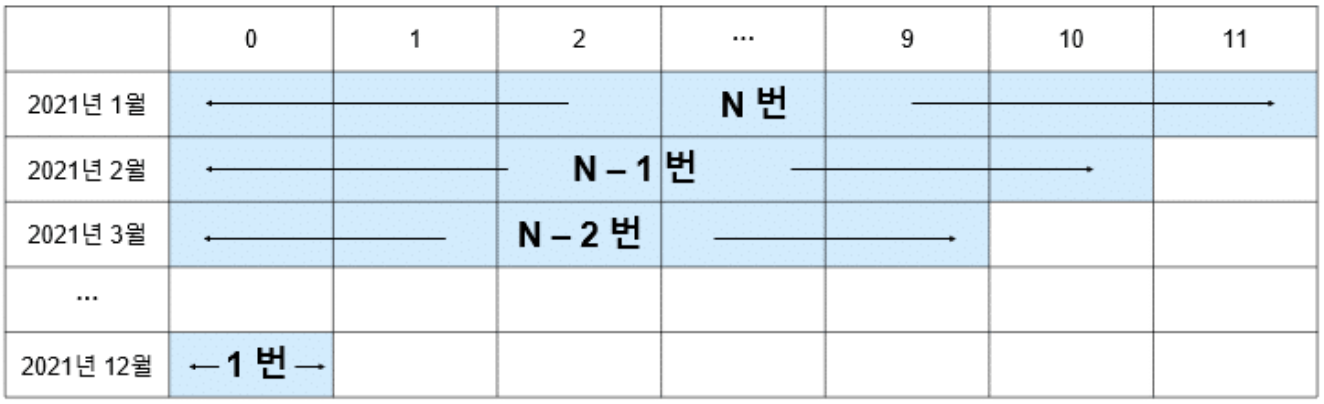

* 현재 데이터는 1년 12달에 대한 cohort를 보기 위한 것 이므로,
    * 12 + 11 + 10 + ... + 3 + 2 + 1 = 총 row 개수 78과 맞는 지 확인 해 보면 된다
    * ( 12 + 1 ) + ( 11 + 2 ) + ... + ( 7 + 6 ) = 13 x 6 = 78

In [ ]:
# 현재 데이터는 1년 12달에 대한 cohort를 보기 위한 것 이므로,
# 12 + 11 + 10 + ... + 3 + 2 + 1
# ( 12 + 1 ) + ( 11 + 2 ) + ... + ( 7 + 6 ) = 13 x 6 = 78

In [ ]:
# 실제로 월마다 모든 cohort 개수가 있는 지 확인
df_users['first_ym'].value_counts()


2021-01    12
2021-02    11
2021-03    10
2021-04     9
2021-05     8
2021-06     7
2021-07     6
2021-08     5
2021-09     4
2021-10     3
2021-11     2
2021-12     1
Name: first_ym, dtype: int64

In [ ]:
df_users

,first_ym,paid_ym,user_key
0,2021-01,2021-01,3781
1,2021-01,2021-02,1805
2,2021-01,2021-03,1381
3,2021-01,2021-04,963
4,2021-01,2021-05,899
...,...,...,...
73,2021-10,2021-11,318
74,2021-10,2021-12,120
75,2021-11,2021-11,840
76,2021-11,2021-12,263


### 3.3.2. Cohort 기간 컬럼 생성

In [ ]:
## 'first_ym'별로 누적합
df_users['cohort_period'] = df_users.groupby(['first_ym']).agg('cumcount')
df_users

,first_ym,paid_ym,user_key,cohort_period
0,2021-01,2021-01,3781,0
1,2021-01,2021-02,1805,1
2,2021-01,2021-03,1381,2
3,2021-01,2021-04,963,3
4,2021-01,2021-05,899,4
...,...,...,...,...
73,2021-10,2021-11,318,1
74,2021-10,2021-12,120,2
75,2021-11,2021-11,840,0
76,2021-11,2021-12,263,1


In [ ]:
df_users [ df_users['first_ym'] =='2021-02']

,first_ym,paid_ym,user_key,cohort_period
12,2021-02,2021-02,1896,0
13,2021-02,2021-03,888,1
14,2021-02,2021-04,546,2
15,2021-02,2021-05,483,3
16,2021-02,2021-06,448,4
17,2021-02,2021-07,447,5
18,2021-02,2021-08,361,6
19,2021-02,2021-09,326,7
20,2021-02,2021-10,307,8
21,2021-02,2021-11,249,9


In [ ]:
# user_cnts: numeric data type 여부 확인
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   first_ym       78 non-null     object
 1   paid_ym        78 non-null     object
 2   user_key       78 non-null     int64 
 3   cohort_period  78 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ KB


### 3.3.3. 기준이 될 것을 index로, 값으로 표현될 것을 컬럼으로 만들기

In [ ]:
#@title 기본 제목 텍스트
df_users.rename(columns = {'user_key': 'user_cnts'}, inplace =True)
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   first_ym       78 non-null     object
 1   paid_ym        78 non-null     object
 2   user_cnts      78 non-null     int64 
 3   cohort_period  78 non-null     int64 
dtypes: int64(2), object(2)
memory usage: 2.6+ KB


### 3.3.4. 값을 기준으로 unstack

In [ ]:
df_cohort = df_users.set_index(['first_ym','cohort_period'])['user_cnts'].unstack()
df_cohort 

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_ym,,,,,,,,,,,,
2021-01,3781.0,1805.0,1381.0,963.0,899.0,879.0,949.0,784.0,756.0,747.0,537.0,307.0
2021-02,1896.0,888.0,546.0,483.0,448.0,447.0,361.0,326.0,307.0,249.0,143.0,NaN
2021-03,1948.0,807.0,650.0,602.0,470.0,387.0,395.0,348.0,284.0,151.0,NaN,NaN
2021-04,1309.0,540.0,421.0,283.0,233.0,236.0,223.0,171.0,80.0,NaN,NaN,NaN
2021-05,1245.0,578.0,384.0,277.0,223.0,208.0,145.0,84.0,NaN,NaN,NaN,NaN
2021-06,1641.0,733.0,473.0,403.0,346.0,208.0,118.0,NaN,NaN,NaN,NaN,NaN
2021-07,2323.0,842.0,589.0,512.0,331.0,175.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-08,933.0,429.0,306.0,188.0,93.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09,1088.0,504.0,266.0,131.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.3.5. unstack 결과를, 첫 코호트 기간의 값으로 나눠주기 → retention 산출

In [ ]:
## 분모
df_cohort[0]

first_ym
2021-01    3781.0
2021-02    1896.0
2021-03    1948.0
2021-04    1309.0
2021-05    1245.0
2021-06    1641.0
2021-07    2323.0
2021-08     933.0
2021-09    1088.0
2021-10     833.0
2021-11     840.0
2021-12    1105.0
Name: 0, dtype: float64

In [ ]:
## 행마다 값으로 나누기 divide
df_retention = df_cohort.divide(df_cohort[0], axis = 0 )
df_retention

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_ym,,,,,,,,,,,,
2021-01,1.0,0.477387,0.365247,0.254695,0.237768,0.232478,0.250992,0.207353,0.199947,0.197567,0.142026,0.081195
2021-02,1.0,0.468354,0.287975,0.254747,0.236287,0.235759,0.190401,0.171941,0.161920,0.131329,0.075422,NaN
2021-03,1.0,0.414271,0.333676,0.309035,0.241273,0.198665,0.202772,0.178645,0.145791,0.077515,NaN,NaN
2021-04,1.0,0.412529,0.321620,0.216196,0.177998,0.180290,0.170359,0.130634,0.061115,NaN,NaN,NaN
2021-05,1.0,0.464257,0.308434,0.222490,0.179116,0.167068,0.116466,0.067470,NaN,NaN,NaN,NaN
2021-06,1.0,0.446679,0.288239,0.245582,0.210847,0.126752,0.071907,NaN,NaN,NaN,NaN,NaN
2021-07,1.0,0.362462,0.253551,0.220405,0.142488,0.075334,NaN,NaN,NaN,NaN,NaN,NaN
2021-08,1.0,0.459807,0.327974,0.201501,0.099678,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09,1.0,0.463235,0.244485,0.120404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# _04. 시각화

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


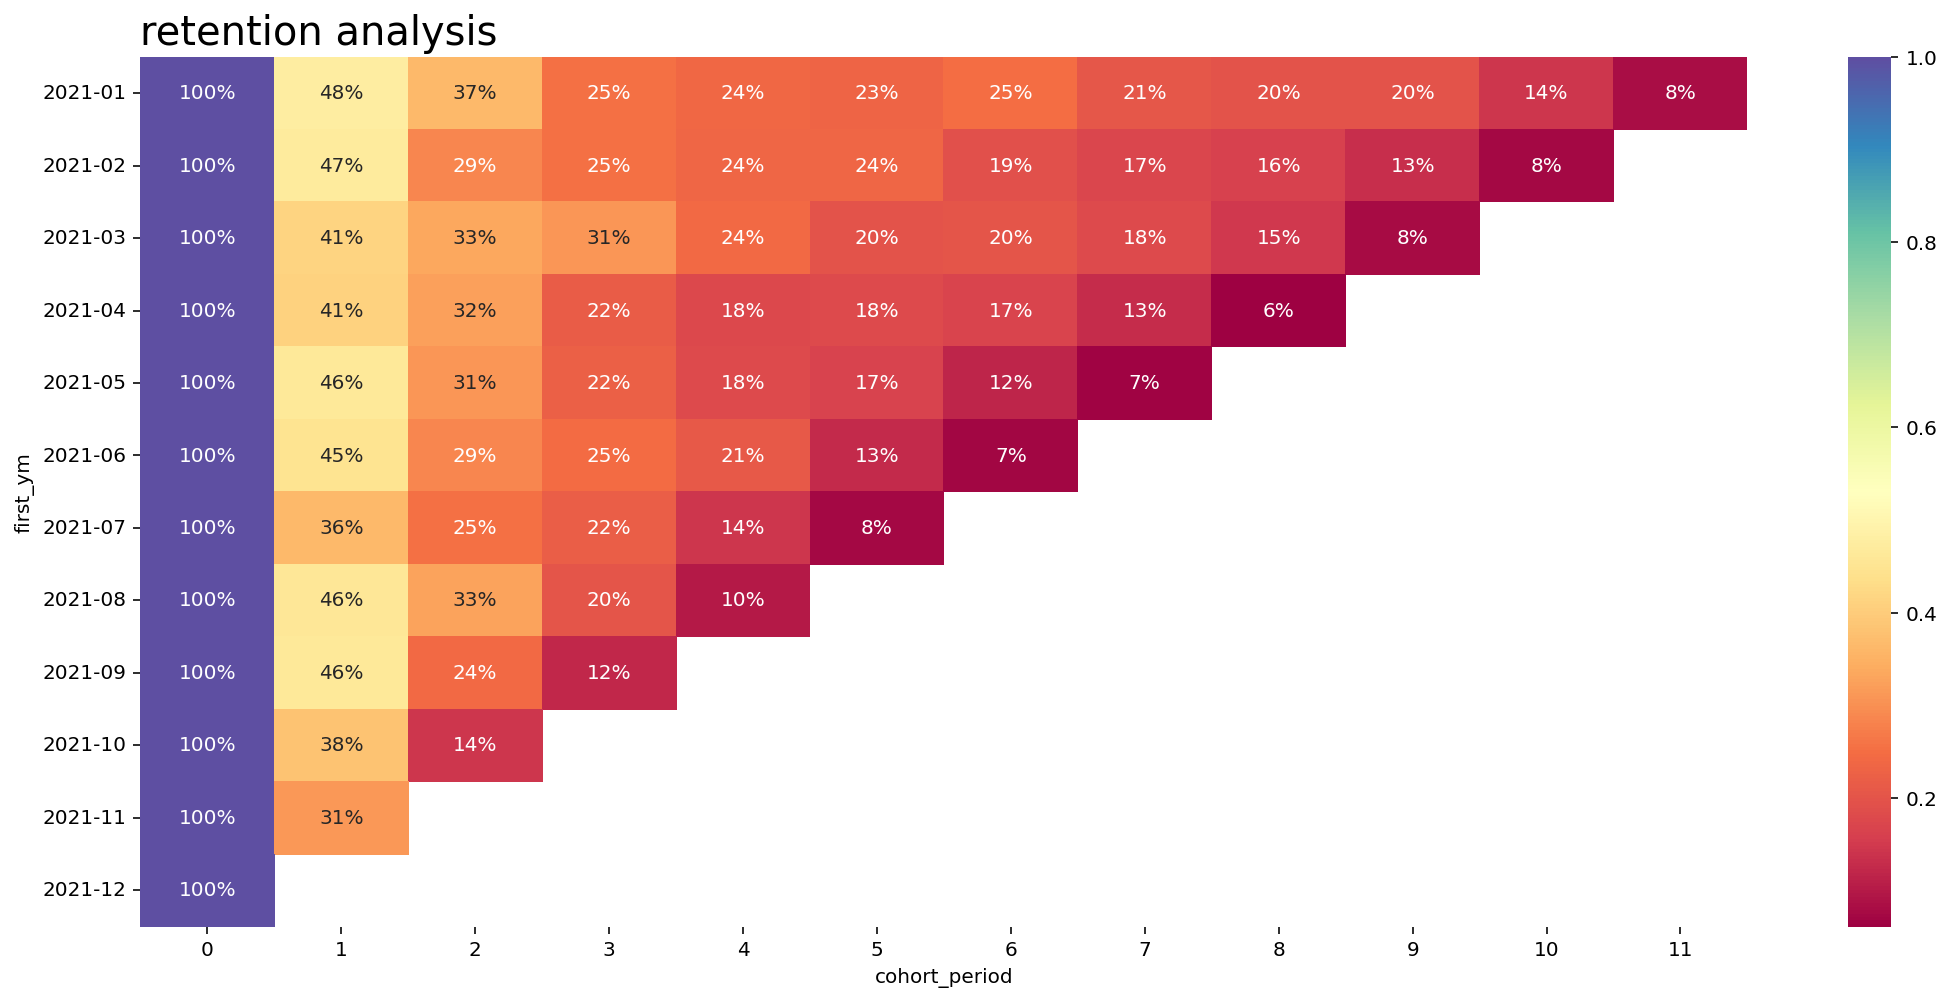

In [ ]:
fig, ax = plt.subplots(nrows =1, ncols =1, figsize=(18,8))

sns.heatmap(data = df_retention,
    annot=True, ##글자유무
    fmt='.0%', ##숫자형식
    cmap= 'Spectral') ##색조합


plt.title('retention analysis', fontsize =20, loc ='left')
plt.show()

*   위의 3.3번의 해당하는 과정을 한 번에




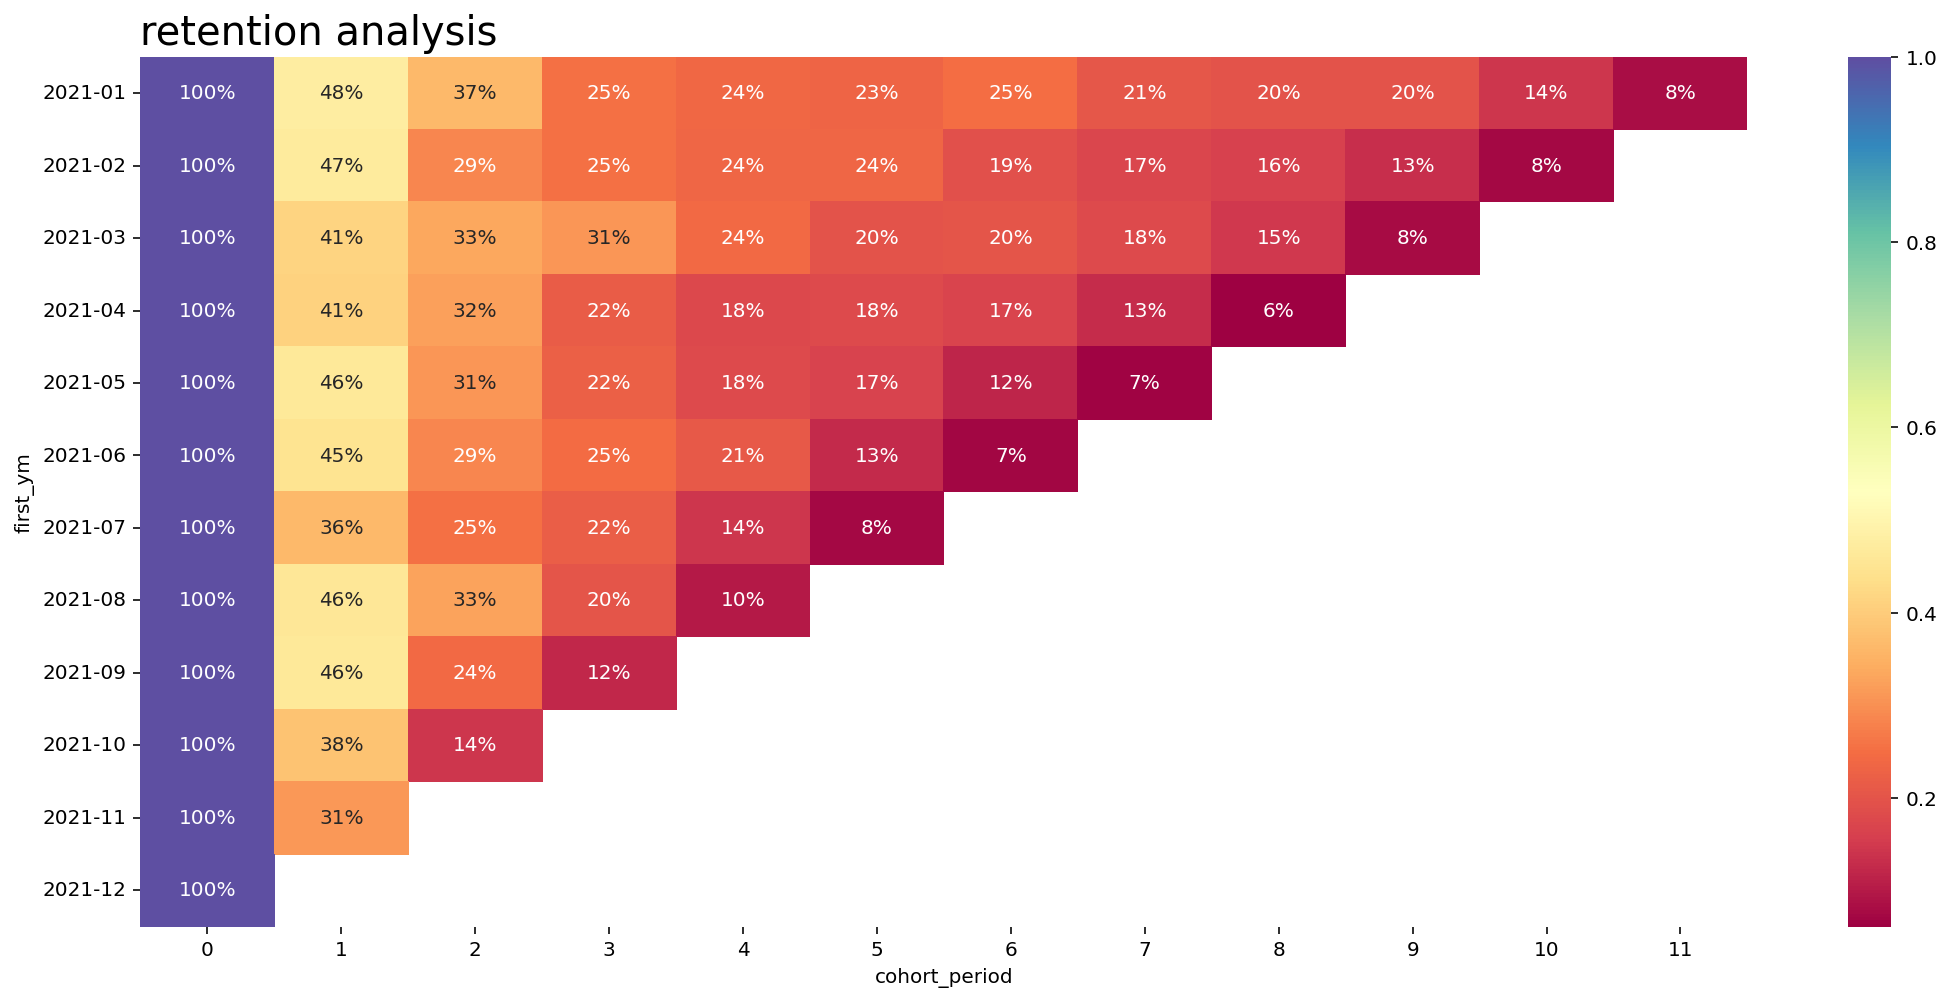

In [ ]:
# temp_df = df_base[df_base['branch'] == temp_branch]
df_users = df_base.groupby(['first_ym','paid_ym'])['user_key'].agg('nunique').reset_index()
df_users['first_ym'].value_counts()
df_users['cohort_period'] = df_users.groupby(['first_ym']).agg('cumcount')
df_users.rename(columns ={'user_key': 'user_cnts'}, inplace =True)
df_cohort = df_users.set_index(['first_ym','cohort_period'])['user_cnts'].unstack()
df_retention = df_cohort.divide(df_cohort[0], axis = 0 )

# 시각화
fig, ax = plt.subplots(nrows =1, ncols =1, figsize=(18,8))

sns.heatmap(data = df_retention,
    annot=True, ##글자유무
    fmt='.0%', ##숫자형식
    cmap= 'Spectral') ##색조합


plt.title('retention analysis', fontsize =20, loc ='left')
plt.show()



# ★ 번외: Cohort x Segmentation

## 7호 & 8호 & 9호점에 대해 별도 cohort

In [ ]:
## 모든 지점에 대한 코호트 이므로, 이번엔 지점별로 리텐션을 보자
df_base.head(2)

,user_key,branch,sales_type,items,paid_date,item_seg,first_paid,paid_ym,first_ym
0,1,01호,매출,자유석,2021-04-11,자유,2021-04-11,2021-04,2021-04
1,2,01호,매출,싱글석,2021-03-28,고정,2021-03-28,2021-03,2021-03


In [ ]:
df_base["branch"].unique().tolist() ## 40개가 넘는 지점들

['01호',
 '02호',
 '03호',
 '04호',
 '05호',
 '06호',
 '07호',
 '08호',
 '09호',
 '10호',
 '11호',
 '12호',
 '13호',
 '14호',
 '15호',
 '16호',
 '17호',
 '18호',
 '19호',
 '20호',
 '21호',
 '22호',
 '23호',
 '24호',
 '25호',
 '26호',
 '27호',
 '28호',
 '29호',
 '30호',
 '31호',
 '32호',
 '33호',
 '34호',
 '35호',
 '36호',
 '37호',
 '38호',
 '39호',
 '40호',
 '41호',
 '42호']

In [ ]:
selected_branches = ['07호','08호','09호']

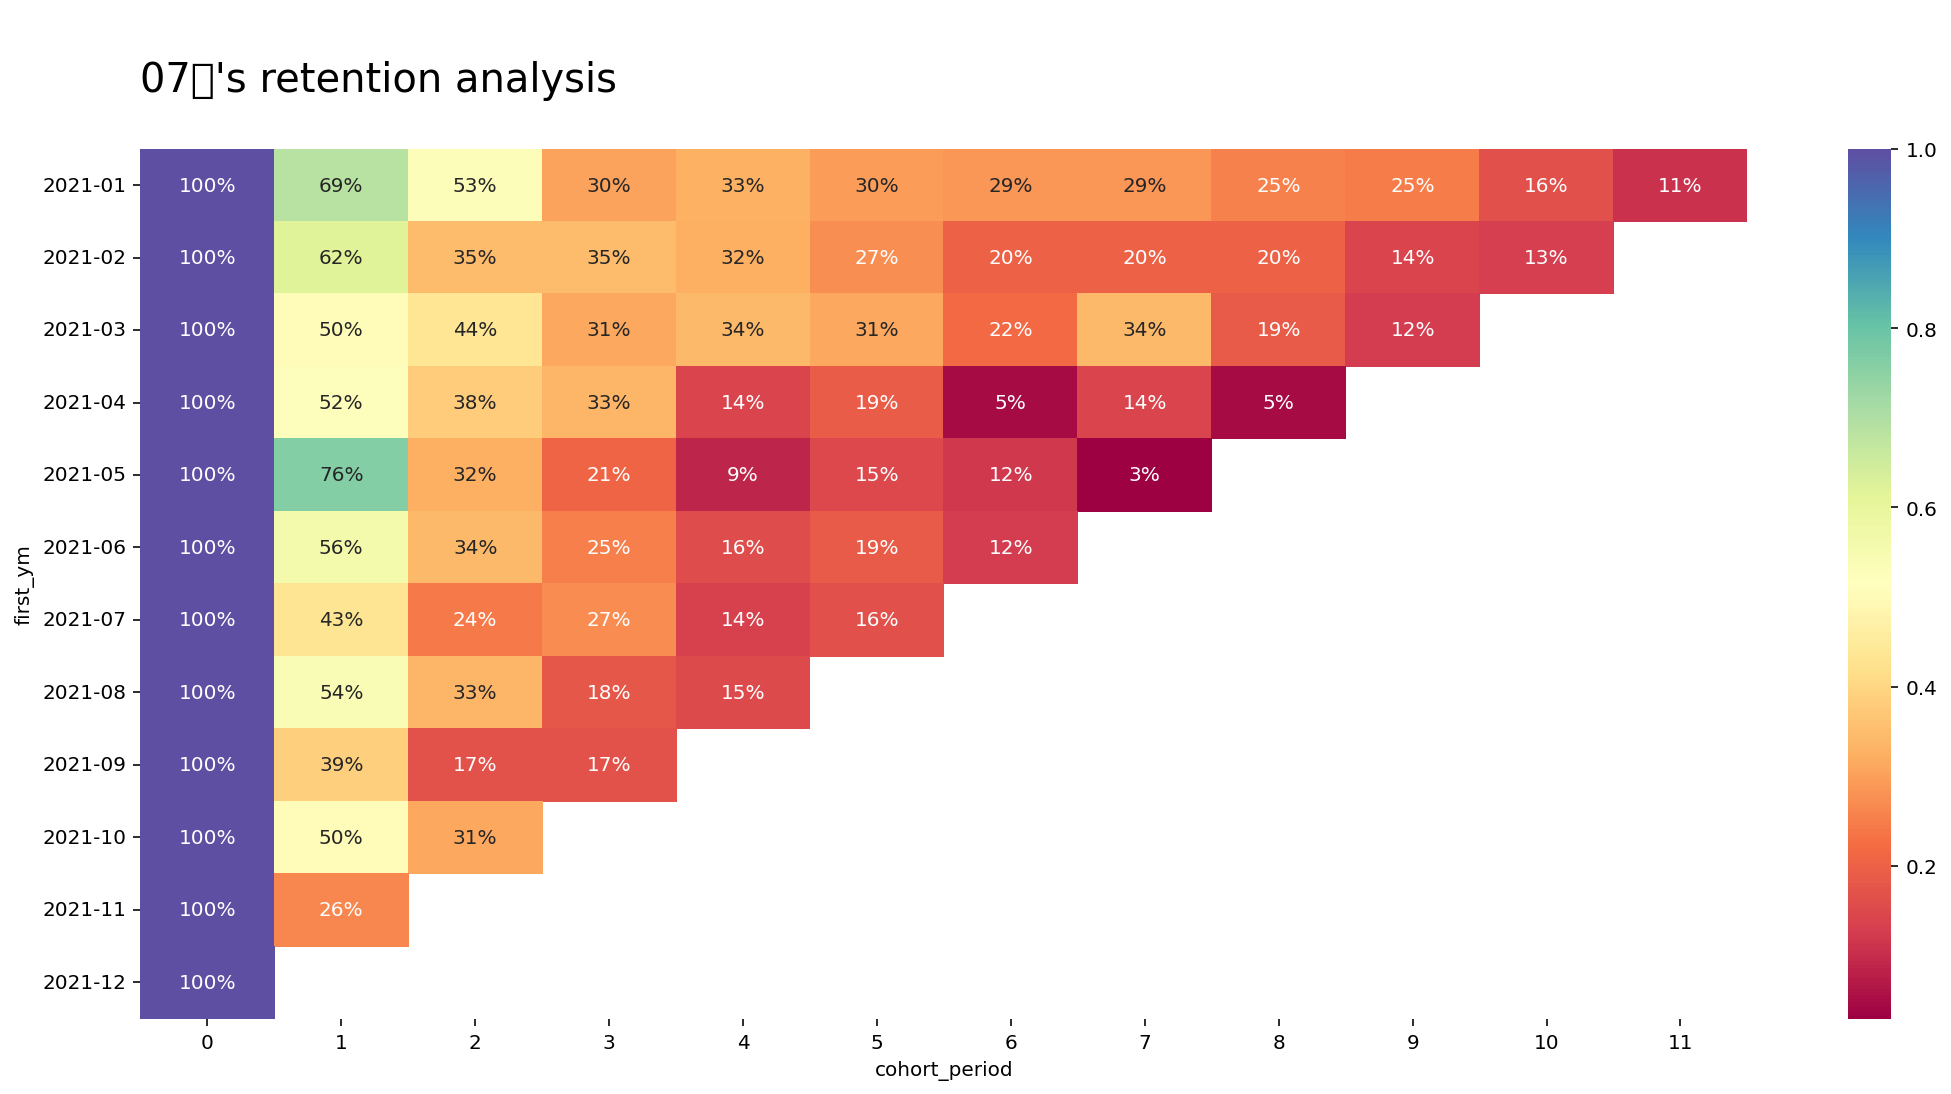

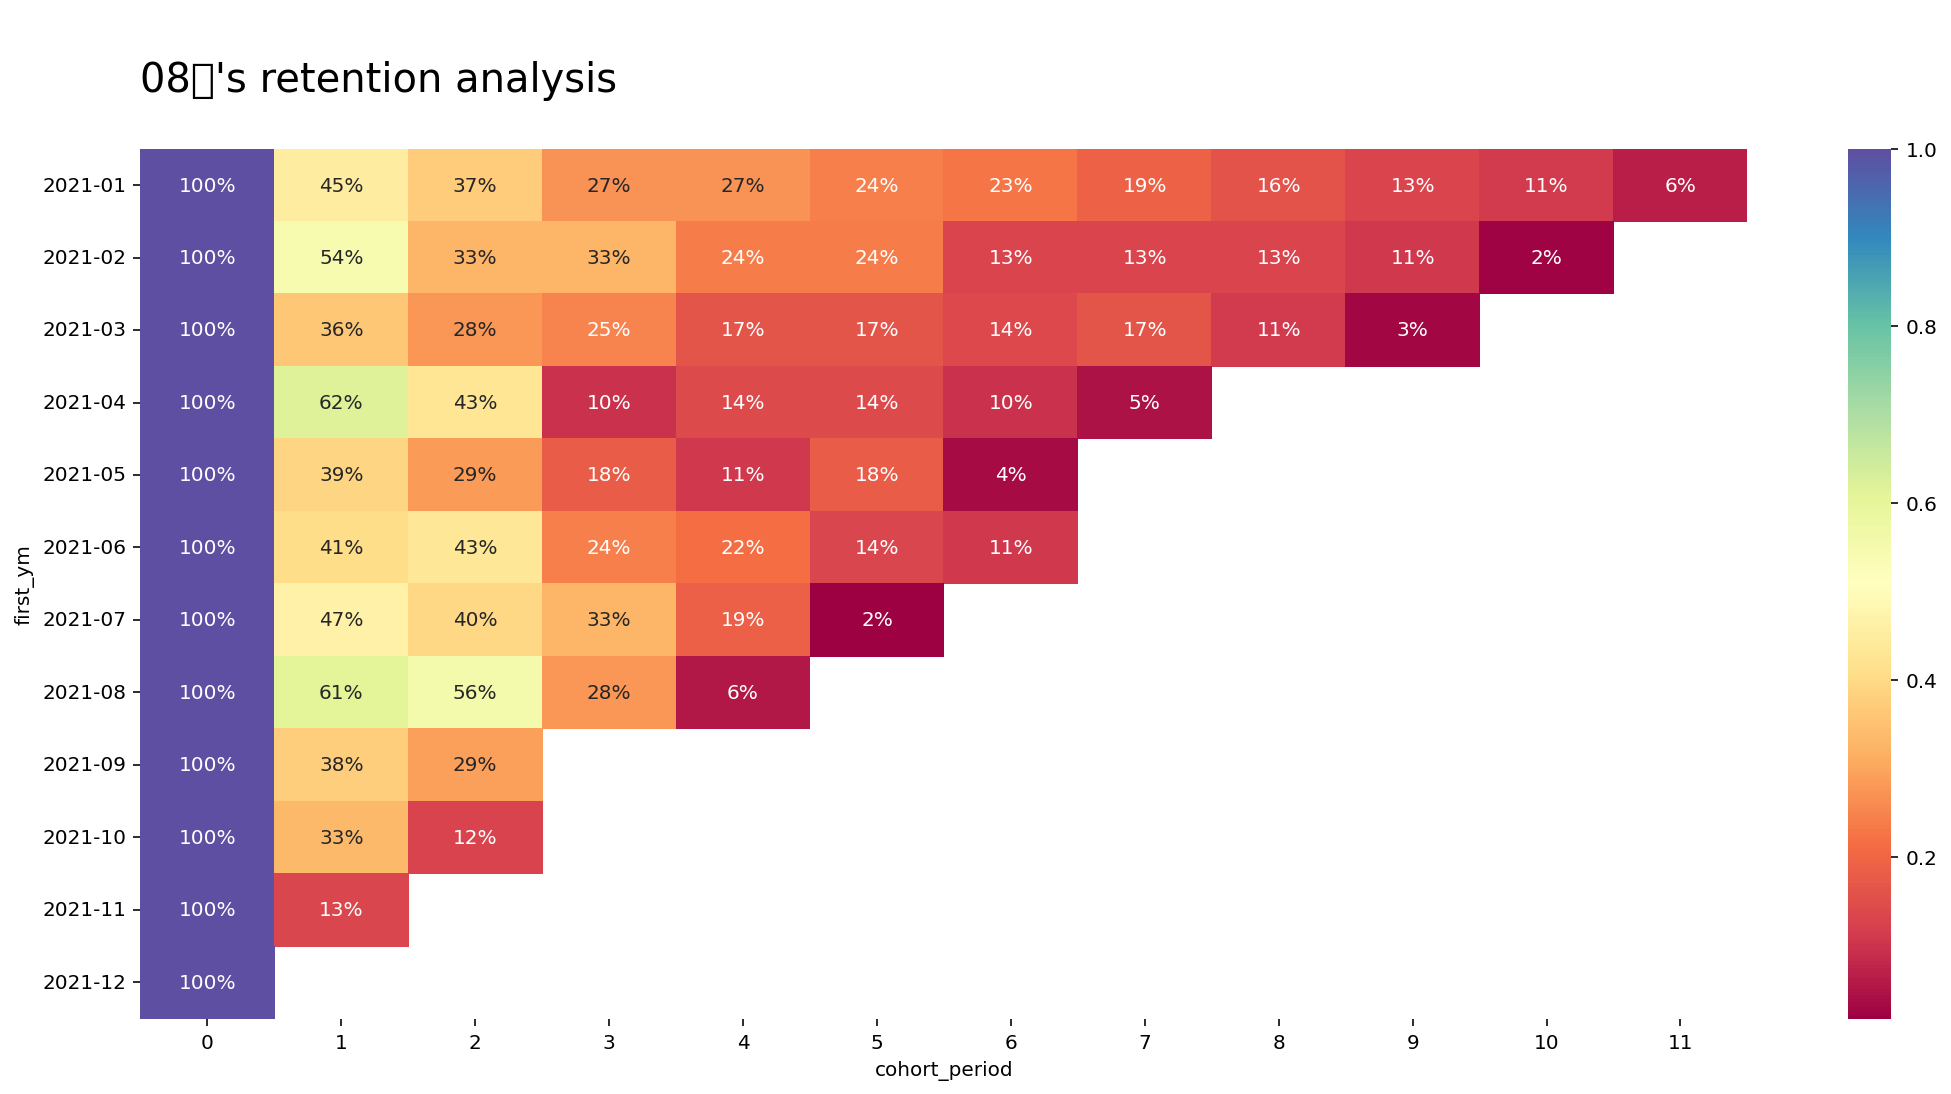

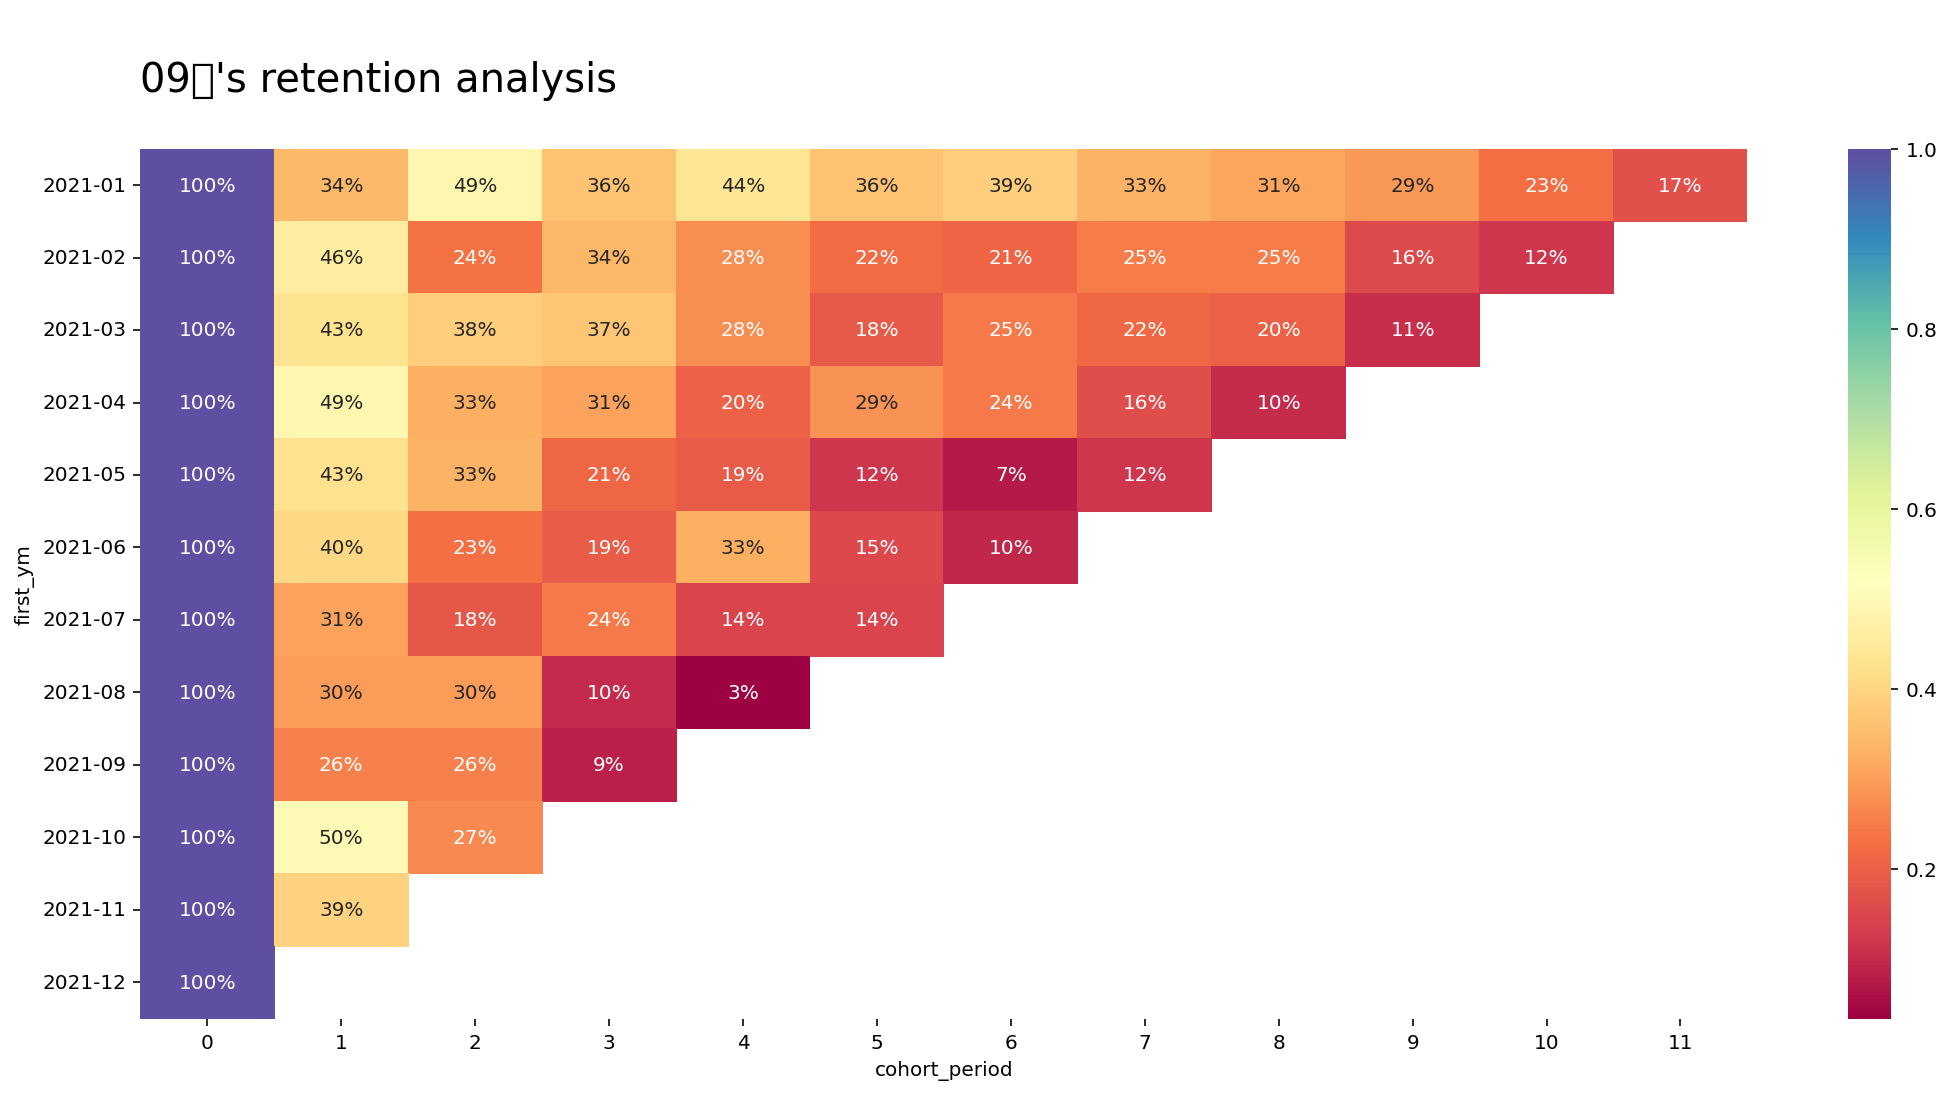

In [ ]:
for temp_branch in selected_branches:

  temp_df = df_base[df_base['branch'] == temp_branch]

  df_users = temp_df.groupby(['first_ym','paid_ym'])['user_key'].agg('nunique').reset_index()
  df_users['first_ym'].value_counts()
  df_users['cohort_period'] = df_users.groupby(['first_ym']).agg('cumcount')
  df_users.rename(columns ={'user_key': 'user_cnts'}, inplace =True)
  df_cohort = df_users.set_index(['first_ym','cohort_period'])['user_cnts'].unstack()
  df_retention = df_cohort.divide(df_cohort[0], axis = 0 )

  # 시각화
  fig, ax = plt.subplots(nrows =1, ncols =1, figsize=(18,8))

  sns.heatmap(data = df_retention,
      annot=True, ##글자유무
      fmt='.0%', ##숫자형식
      cmap= 'Spectral') ##색조합


  plt.title(f'\n{temp_branch}\'s retention analysis\n', fontsize =20, loc ='left')
  plt.show()


## 빠진 이 채우기: 08호점

In [ ]:
# first_ym 2021-04: 9개 있어야 하지만 8개 있음
# first_ym 2021-05: 8개 있어야 하지만 7개 있음
# first_ym 2021-09: 4개 있어야 하지만 3개 있음

In [ ]:
# ↑ 저곳의 data frame에, paid_ym 2021-12가 빠져있음

In [ ]:
# ↑ 저곳의 data frame에, paid_ym 2021-12가 빠져있음

In [ ]:
# ↑ 저곳의 data frame에, paid_ym 2021-12가 빠져있음

In [ ]:
# 채우기 전 data frame


In [ ]:
# first_ym 2021-04 // 2021-05 // 2021-09에 각각 paid_ym 2021-12가 빠져있음

In [ ]:
df_8_user

NameError: ignored

In [ ]:
# 완성

In [ ]:
# 빠진 이 끼워맞춘 것 확인



In [ ]:
df_base.head()

## 결제항목( item_seg ) 조합 추가

In [ ]:
df_base['item_seg'].unique().tolist()